In [1]:
import sys 
from pathlib import Path
import torch
import os
# import dill
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path
import cv2
import time


sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to


from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info

import robomimic
import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.config import config_factory
from robomimic.algo import algo_factory, RolloutPolicy
from robomimic.utils.log_utils import PrintLogger, DataLogger, flush_warnings


import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils


from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

ModuleNotFoundError: No module named 'deoxys_vision'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type

spacemouse = SpaceMouse(vendor_id=9583, product_id=50734) 
#old spacemoue not wireless
# spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()
raw_obs_dict_generator = RobotStateRawObsDictGenerator()

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: SpaceMouse Wireless

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [ ]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

### reset robot position (no need to do it from terminal)

In [ ]:
# copied from reset_robot_joints.py
# Golden resetting joints
reset_joint_positions = [
    0.09162008114028396,
    -0.19826458111314524,
    -0.01990020486871322,
    -2.4732269941140346,
    -0.01307073642274261,
    2.30396583422025,
    0.8480939705504309,
]

In [ ]:
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


### getting lowdim obs + camera obs

In [ ]:
camera_ids = [0, 1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


In [ ]:
def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]

        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))

        # color_img = cv2.resize(color_img, (224, 224))  
        color_img = cv2.resize(color_img, None, fx=0.5, fy=0.5)

        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

In [ ]:
data = get_imgs()
print('keys: ', data.keys())

img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
agentview_rgb.shape, eye_in_hand_rgb.shape

keys:  dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])


((240, 320, 3), (240, 320, 3))

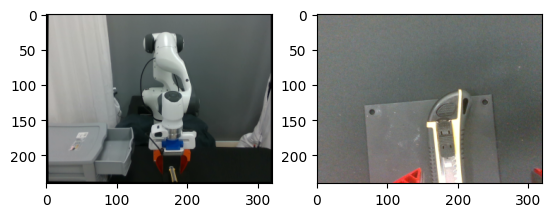

In [ ]:
plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [ ]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]

    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [ ]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 320, 240)
eye_in_hand_rgb (1, 3, 320, 240)


### now load trans policy

In [ ]:
# ckpt_path = "/home/franka_deoxys/data_franka/policies/drawer_trans_lay53/model_epoch_400.pth"
ckpt_path = "/home/franka_deoxys/data_franka/policies/drawer_trans_lay53/trans_2p5_model_epoch_320.pth"



assert os.path.exists(ckpt_path)

 
# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=False)
ckpt_dict = FileUtils.maybe_dict_from_checkpoint(ckpt_path=ckpt_path, ckpt_dict=None)
# algo name and config from model dict
algo_name, _ = FileUtils.algo_name_from_checkpoint(ckpt_dict=ckpt_dict)
config, _ = FileUtils.config_from_checkpoint(algo_name=algo_name, ckpt_dict=ckpt_dict, verbose=False)

config.unlock()
config.train.data="/media/franka_deoxys/DATA/demo_rss_paper/drawer/zahid11/demo.hdf5"
config.lock() 


ObsUtils.initialize_obs_utils_with_config(config)

# shape_meta = FileUtils.get_shape_metadata_from_dataset(
#     dataset_path=config.train.data,
#     all_obs_keys=config.all_obs_keys,
#     verbose=False
# )
# trainset, validset = TrainUtils.load_data_for_training(
#     config, obs_keys=shape_meta["all_obs_keys"])
# len(trainset.demos)

/home/franka_deoxys/robomimic/robomimic/utils/file_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_dict = torch.load(ckpt_path)



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'ee_states', 'gripper_states']
using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Created GPT_Backbone model with number of parameters: 18906112

============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'ee_states', 'gripper_states']
using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


In [ ]:
model = policy.policy
model.set_eval()

In [ ]:
# num_frames=10
# framestacker=FrameStackForTrans(num_frames=num_frames)

In [ ]:
framestacker=FrameStackForTrans(10)
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [ ]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

ee_states (16,)
joint_states (7,)
gripper_states (1,)
agentview_rgb (3, 320, 240)
eye_in_hand_rgb (3, 320, 240)


In [ ]:
init_obs =get_current_obs(robot_interface)
obs=framestacker.reset(init_obs)

In [ ]:
init_obs =get_current_obs(robot_interface)
obs=framestacker.reset(init_obs)
obs=TensorUtils.to_torch(obs, device=device)

batch_obs={key:obs[key][None] for key in obs} 
pred = model.get_action(obs_dict=batch_obs , goal_dict=None)
ac=pred.detach().cpu().numpy().squeeze()
ac

array([-0.   ,  0.002, -0.004, -0.   , -0.001, -0.003,  0.   ],
      dtype=float32)

In [ ]:
obs_t = get_current_obs(robot_interface)
obs=framestacker.add_new_obs(obs_t)
obs=TensorUtils.to_torch(obs, device=device)
batch_obs={key:obs[key][None] for key in obs} 
pred = model.get_action(obs_dict=batch_obs , goal_dict=None)
action=pred.detach().cpu().numpy().squeeze() 
action 

array([ 0.004, -0.004, -0.023,  0.004,  0.004, -0.001, -0.   ],
      dtype=float32)

In [ ]:
import h5py 
hdf5_file_path = "/media/franka_deoxys/DATA/demo_rss_paper/drawer/zahid11/demo.hdf5"
file = h5py.File(hdf5_file_path, "r")
demos = file['data']
demo = file['data']['demo_1']

In [ ]:
demo['actions'][:][0]

array([ 0.183, -0.009, -0.   ,  0.   ,  0.05 , -0.   , -1.   ])

In [ ]:
prev_pos = np.array([0, 0, 0, 0, 0, 0, -1])
# prev_pos = np.array([ 0.183, -0.009, -0.   ,  0.   ,  0.05 , -0.   , -1.   ])

In [ ]:
new_pos = prev_pos + action
new_pos 

array([ 0.,  0.,  0.,  0.,  0.,  0., -1.])

### Now run inference in loop

In [ ]:
# reset robot
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


In [ ]:
controller_type

'OSC_POSE'

In [ ]:
controller_type = 'CARTESIAN_VELOCITY'
controller_type = 'OSC_POSE'

In [ ]:
# policy.reset()
 
images = []
actions_executed = []
for _ in range(500):
    action, grasp = input2action(
        device=spacemouse,
        controller_type=controller_type,
    )
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    obs_t = get_current_obs(robot_interface)
    imgs1=obs_t['agentview_rgb']
    imgs2=obs_t['eye_in_hand_rgb']
    img=np.concatenate([imgs1, imgs2], axis=1).transpose(2,1,0)
    images.append(img)


    obs=framestacker.add_new_obs(obs_t)
    obs=TensorUtils.to_torch(obs, device=device)
    batch_obs={key:obs[key][None] for key in obs} 
    pred = model.get_action(obs_dict=batch_obs , goal_dict=None)
    action=pred.detach().cpu().numpy().squeeze() 

    new_pos = prev_pos + action*(1.0/2.5)
    action = new_pos 
    actions_executed.append(action)

    robot_interface.control(
        controller_type=controller_type,
        action=action,
        controller_cfg=controller_cfg,
    )

    prev_pos = new_pos

    time.sleep(0.045)

    
robot_interface.close()

KeyboardInterrupt: 

In [ ]:
actions_executed

[array([ 0.002, -0.002, -0.01 ,  0.001,  0.002, -0.001, -1.   ]),
 array([ 0.002, -0.001, -0.012,  0.001,  0.001, -0.002, -1.   ]),
 array([-0.001, -0.022, -0.018,  0.002,  0.001, -0.004, -1.   ]),
 array([-0.002, -0.022, -0.018,  0.002,  0.001, -0.005, -0.999]),
 array([-0.001, -0.024, -0.028,  0.003,  0.003, -0.005, -0.999]),
 array([-0.002, -0.023, -0.028,  0.003,  0.003, -0.005, -0.999]),
 array([-0.003, -0.023, -0.029,  0.003,  0.003, -0.006, -0.999]),
 array([-0.004, -0.023, -0.029,  0.002,  0.003, -0.006, -0.999]),
 array([-0.002, -0.025, -0.039,  0.004,  0.005, -0.006, -0.999]),
 array([-0.002, -0.024, -0.041,  0.004,  0.004, -0.008, -0.999]),
 array([-0.003, -0.024, -0.041,  0.004,  0.004, -0.008, -0.999]),
 array([-0.005, -0.024, -0.042,  0.003,  0.005, -0.008, -0.999]),
 array([-0.006, -0.024, -0.042,  0.003,  0.005, -0.009, -0.998]),
 array([-0.005, -0.024, -0.044,  0.003,  0.004, -0.01 , -0.998]),
 array([-0.007, -0.023, -0.045,  0.003,  0.004, -0.01 , -0.998]),
 array([-0

### saving the images as video file

In [ ]:
import imageio 
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d_%H_%M")
savepath = f"inference_videos/trans_{now}.mp4"

print('saving video to: ', savepath)

writer = imageio.get_writer(savepath, fps=10)
for img in images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    writer.append_data(img)
writer.close()

saving video to:  inference_videos/trans_2024-12-29_14_15.mp4


In [ ]:
actions_executed

[array([ 0.184, -0.007,  0.001,  0.001,  0.05 ,  0.001, -1.001]),
 array([ 0.185, -0.006,  0.002,  0.002,  0.05 ,  0.001, -1.001]),
 array([ 0.186, -0.005,  0.003,  0.003,  0.049,  0.002, -1.002]),
 array([ 0.185, -0.003, -0.005,  0.003,  0.049,  0.002, -1.003]),
 array([ 0.186, -0.001, -0.004,  0.004,  0.048,  0.002, -1.003]),
 array([ 0.187,  0.   , -0.003,  0.005,  0.048,  0.003, -1.004]),
 array([ 0.186,  0.002, -0.012,  0.004,  0.047,  0.003, -1.005]),
 array([ 0.185,  0.003, -0.02 ,  0.003,  0.047,  0.003, -1.006]),
 array([ 0.186,  0.005, -0.019,  0.004,  0.047,  0.003, -1.007]),
 array([ 0.187,  0.006, -0.018,  0.006,  0.046,  0.004, -1.008]),
 array([ 0.188,  0.008, -0.018,  0.007,  0.046,  0.005, -1.008]),
 array([ 0.189,  0.009, -0.017,  0.008,  0.045,  0.005, -1.009]),
 array([ 0.19 ,  0.011, -0.016,  0.009,  0.045,  0.005, -1.01 ]),
 array([ 0.191,  0.012, -0.015,  0.01 ,  0.045,  0.006, -1.01 ]),
 array([ 0.189,  0.016, -0.01 ,  0.018,  0.039,  0.004, -2.01 ]),
 array([ 0